# Statistical analysis

The following procedure is a simplification of the full hypothesis test gathered from the CMS - NOTE 2011-005. The CMS - NOTE 2011-005 describes the statistical approach used to determine whether the Higgs boson mass value found from the data from the particle collider, originates from an actual signal in combination with background noise, or if it is simply due to only background noise. 

The statistical procedure with the choice of the test statistics is summarised below,

1. Construct the likelihood function
$$\mathcal{L}\left(\mbox{data}|\mu,\theta\right) = \mbox{Poisson}\left(\mbox{data}|\mu \cdot s\left(\theta\right) + b\left(\theta\right)\right)\cdot p\left(\tilde{\theta}|\theta\right)$$

* Data represents either actual experimental observation or pseudo-data used to construct sampling distributions

* $\mu$ is the signal strength modifier and $\theta$ represents the full suite of nuiance parameters

* Poissons(data|$\mu s + b$) stands for a product of Poisson probabilities to observe $n_i$ events in bins $i$:
$$\prod_{i} \frac{\left(\mu s_i + b_i\right)^{n_i}}{n_i !} e^{-\mu s_i - b_i}$$

2. To compare the compability of the data with the background -only and signal + background hypothesis, the test statistic $\tilde{q_{\mu}} $ is used: $$\tilde{q_{\mu}} =  - 2ln \frac{\mathcal{L}\left(\mbox{data}|\mu, \hat{\theta_{\mu}}\right)}{\mathcal{L}\left(\mbox{data}|\hat{\mu}, \hat{\theta}\right)},$$  
with $0 \leq \hat{\mu} \leq \mu$, and $\hat{\mu}$ and $\hat{\theta}$ are the values that corresponds to the global maximum of the likelihood.

3. Compute $\tilde{q_{\mu}}^{obs}$, $\hat{\theta_{\mu}}^{obs}$, $\hat{\theta_{0}}^{obs}$ for the $\mu$ value tested.

4. Generate toy Monte Carlo pseudo-data to construct pdfs $f\left(\tilde{q_{\mu}}|\mu, \hat{\theta_{\mu}}^{obs}\right)$ and $f\left(\tilde{q_{\mu}}|0, \hat{\theta_{0}}^{obs}\right)$ assuming a signal with strength $\mu$ in the signal+background hypothesis and for the background-only hypothesis ($\mu$ = 0).

5. Having constructed $f\left(\tilde{q_{\mu}}|\mu, \hat{\theta_{\mu}}^{obs}\right)$ and $f\left(\tilde{q_{\mu}}|0, \hat{\theta_{0}}^{obs}\right)$ distributions, define two p-values to be associated with the actual observation for the signal + background and background-only hypothesis, $p_{\mu}$ and $p_b$:
$$p_{\mu} = P\left(\tilde{q_{\mu}} \geq \tilde{q}_{\mu}^{obs}|\mbox{signal + background}\right) = \int_{\tilde{q}_{\mu}^{obs}}^{infty} f\left(\tilde{q}_{\mu}|\mu, \hat{\theta_{\mu}}^{obs}\right) d\tilde{q_{\mu}} $$

$$1- p_{b} = P\left(\tilde{q_{\mu}} \geq \tilde{q}_{\mu}^{obs}|\mbox{background only}\right) = \int_{\tilde{q}_{\mu}^{obs}}^{infty} f\left(\tilde{q}_{\mu}|0, \hat{\theta_{0}}^{obs}\right) d\tilde{q_{\mu}}$$

and calculate $CL_{s}\left(\mu\right) = \frac{p_{\mu}}{1-p_{b}}$.

6. To quote the 95$\%$ Confidence Level upper limit on $\mu$, to be further denoted as $\mu^{95\%CL}$ we adjust $\mu$ until we reach $CL_s = 0.05$ and we would state that the SM Higgs boson is excluded with 95$\%$ Confidence Level.




## Importing necessary packages

In general the statistical procedure has been implemented by using arrays, lists and statistical functions. No additional pre-made packages were used, as we wanted to gain insight in the actual steps of the procedure. However, the package pyhf was used to check the results of our own method in the beginning to make sure we had implemented some of the functions correctly.

In [2]:
# Packages needed to do the procedure
import ROOT
import math
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as ss
import scipy.integrate as integrate
import scipy.special as special
import scipy.integrate as integrate
from scipy.integrate import quad
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure
import pyhf
from tqdm import tqdm
import seaborn as sns

Welcome to JupyROOT 6.26/04


## Uploading data and checking the correspondence between data and simulations

The data has been processed to collect all events of 2 muon pairs or a muon pair coupled with an electron pair, as these are considered indicators of a Higgs-boson having decayed to a Z-boson pair. Only pairs with m>100 GeV has been considered.

In [8]:
#Uploading data
sim_signal_counts     = np.load(r'signal_counts.npy')
sim_background_counts = np.load(r'background_counts.npy')
true_counts           = np.load(r'true_counts.npy')
bin_counts            = np.load(r'bins.npy')

To visualize the correspondence between the real data and the simulations, the counts of the simulated data and the real data
are plotted together in an histogram. The simulated signal is plotted in red, the simulated background in blue, and the counts of the real data has been added in black on top. As one can see, the findings of the simulated and the real data correspond quite well.

Text(0, 0.5, 'Counts')

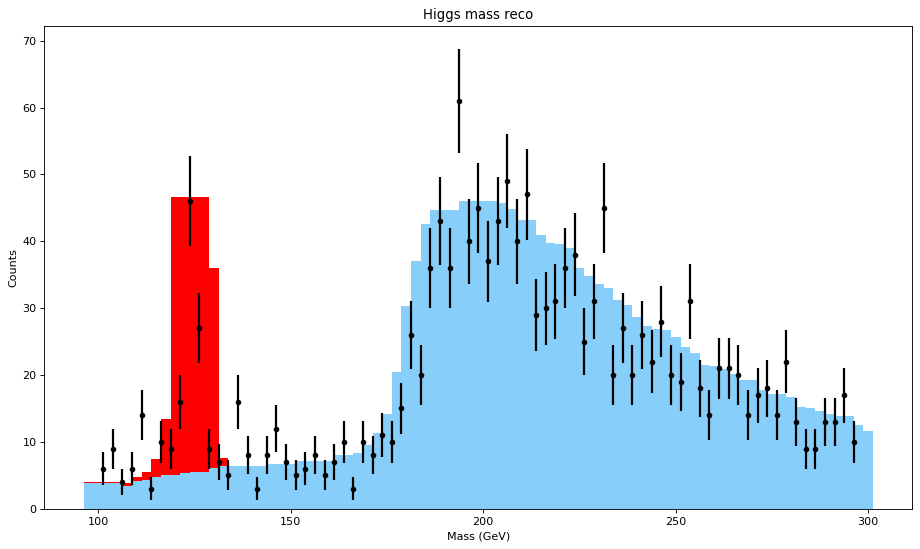

In [9]:
figure(figsize=(14, 8), dpi=80)
width = 10

bincenters = ( bin_counts[1:] + bin_counts[:-1]) / 2

plt.errorbar( bincenters, true_counts,
              yerr   = np.sqrt(true_counts),
              markersize  = 8,
              fmt    = '.', 
              color  = 'black',
              linewidth = 2)
plt.bar(bincenters[0:,], sim_background_counts + sim_signal_counts , 
        color = 'red', alpha = 1, 
        width = width  )
plt.bar(bincenters[0:,], sim_background_counts , 
        color = 'lightskyblue', alpha = 1, 
        width = width )
plt.title("Higgs mass reco")
plt.xlabel("Mass (GeV)")
plt.ylabel("Counts")

## Defining necessary functions

In order to proceed with the statistical analysis of the data, we must define and implement the likelihood-function

$$\mathcal{L}\left(\mbox{data}|\mu,\theta\right) = \mbox{Poisson}\left(\mbox{data}|\mu \cdot s\left(\theta\right) + b\left(\theta\right)\right)\cdot p\left(\tilde{\theta}|\theta\right)$$

and the test statistic $$\tilde{q_{\mu}} =  - 2ln \frac{\mathcal{L}\left(\mbox{data}|\mu, \hat{\theta_{\mu}}\right)}{\mathcal{L}\left(\mbox{data}|\hat{\mu}, \hat{\theta}\right)},$$ 

In addition the functions for generating toy data are defined by using scipy.stats, and a function to gather the value of $\mu$ that maximizes the likelihood-function for a given set of data. The latter was done by using scipy.optimize.minimize to find the minimum of the log.likelihood function multiplied by -1.

In [13]:
# We can assume the data we are getting in is an array of discrete counts;
# The likelihood function for each bin is given by the poisson distribution
# pmf(k, mu, loc=0)

# log of likelihood function to avoid underflow


def log_likelihood(params, s = sim_signal_counts,
                           b = sim_background_counts,
                           n = true_counts):
    """ 
    params[0] = signal strength parameter mu
    params[1] = nuisance parameter theta
    s         = number of expected signal events in bin i 
    b         = number of expected background events in bin i 
    n         = number of real events in bin i 
    """

    nu = (params[0]*s) + b
    log_poiss_pdf = sum(np.log(ss.poisson.pmf(n,nu)))
    theta_pdf     = ss.norm.pdf(x = params[1], loc = 0, scale = 0.15)
  
    return log_poiss_pdf + np.log(theta_pdf)

# we construct the test statistic q ̃_mu based on the profile likelihood ratio:

def q_tilde_mu(mu_1, theta1, mu_2, theta2,
                n = true_counts, 
                s = sim_signal_counts, 
                b = sim_background_counts,
                func=log_likelihood):
    
    log_val = func([mu_1, theta1],s, b, n) - func([mu_2, theta2],s, b, n)
    
    return -2*log_val 


# Functions for generating toy Monte Carlo pseudo-data to 
# construct pdfs f(q^~_μ |μ) and f (q^ ̃_μ |0 )
# assuming a signal with strength μ in the signal+background 
# hypothesis and for the
# background-only hypothesis (μ = 0). 

def create_toy(mu, s, b ):
    """
    Return a random Poisson distributed value
    with mu*s + b as its expected value
    """
        
    return ss.poisson.rvs((mu*s)+b,size=1)


def create_toy_distr(mu,s,b,func = create_toy):
    
    """
    Generate for each bin a random Poisson 
    distributed values in according to the 
    counts for simulated signal and background 
    """
    
    toys_list = np.zeros(len(s))
    for i in range(len(s)):
        toys_list[i] = func(mu,s[i],b[i])
        
    return toys_list


# loop over all the different toy-datasets
# and calculate the optimal mu for each of them

def get_params_max( df, s, b ):
   
    n_toys  = len(df.iloc[:,0])
    mu_s    = np.zeros(n_toys)
    thets_s = np.zeros(n_toys)

    for i in range(n_toys):
        fun = lambda x: -log_likelihood(x, s, b, n = df.iloc[i,:])
        params_opt_i  = sp.optimize.minimize(fun, (0.5, 0.5), bounds=((0,1),(-5, 5)))
        mu_s[i],  thets_s[i] = params_opt_i["x"]
    
    return mu_s, thets_s


# Analysis

### Finding $\hat{\mu}$ of our original data

First we must find $\hat{\mu}$ and $\hat{\theta}$ the value that maximize the likelihood function for our original data, where $\mu \in [0,1]$.

In [72]:
fun = lambda x: -log_likelihood(x)

params_opt = sp.optimize.minimize(fun,(0.5, 0.5),bounds=((0,1),(-1,1)))

mu_max, theta_max = params_opt["x"]

print("The best fit value of mu for our original data is: ", mu_max)
print("The best fit value of theta for our original data is: ", theta_max)

mu    = np.linspace( 1, 0.01, 100)
theta = np.linspace(-1, 1, 100)


likelihood_val = np.zeros((len(mu), len(theta)))

for i in range(len(mu)):
    for j in range(len(theta)):
        Z = log_likelihood([mu[i],theta[j]])

        likelihood_val[i][j] = Z


The best fit value of mu for our original data is:  0.9571142266134196
The best fit value of theta for our original data is:  -4.5146978451990683e-07


Doing this, we find that the value of $\mu$ that maximizes the likelihood function for our original dataset is $\hat{\mu}=0.957$. This means the likelihood -function is maximized with the presence of a strong signal. This can be visualized in a 3D-plot, showing the peak of our likelihood-function.

Text(0.5, 0.5, '$\\Theta$')

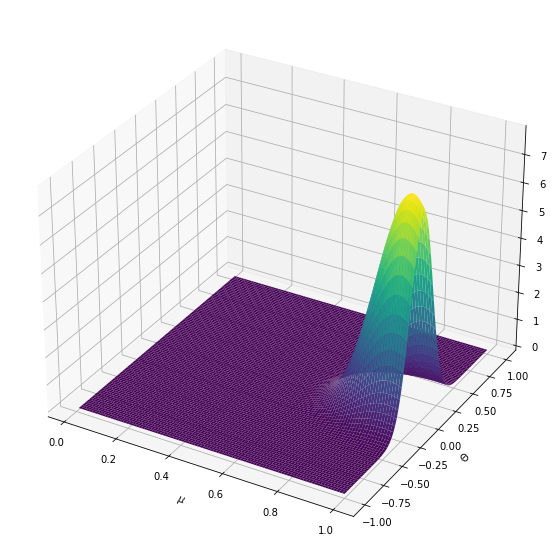

In [61]:
X, Y = np.meshgrid( theta, mu )

ax   = plt.figure( figsize = ( 15, 10 ) )

ax   = plt.axes( projection = '3d', 
                 label ='z' )

ax.plot_surface( Y, X, np.exp(likelihood_val), 
                 rstride = 1, 
                 cstride = 1,
                 cmap    = 'viridis',
                 edgecolor = 'none')
#ax.set_xlim( 0, 1 )
ax.set_xlabel( '$\mu$' )
ax.set_ylabel( '$\Theta$' )

## Costructing the pdf of $ \tilde{q}_{\mu} $ generating toy pseudo-data

Moving on, we need to construct the pdf's of our test-statistc $\tilde{q}_{\mu}$. The range for $\mu$ is 100 values in the interval $[0,1]$. For each chosen value of $\mu$, 4000 data-toys are generated by drawing from a poisson distribution with $\lambda = s \cdot \mu + b$, where $s$ and $b$ are the simulated signal and- background data respectively. For each value of $\mu$, the test-statistic $\tilde{q}_{\mu}^{obs}$ is calculated under the signal+background and for the background-only hypothesis from the generated toy-data. These become our distributions for $\tilde{q}_{\mu}$ under the signal+background and for the background-only hypothesis, respectively $f\left(\tilde{q_{\mu}}|\mu, \hat{\theta_{\mu}}^{obs}\right)$,
$f\left(\tilde{q_{\mu}}|0, \hat{\theta_{0}}^{obs}\right)$ .

In [22]:
# Find Theta_0_max obs and Theta_mu_max obs:

fun    = lambda x:  - log_likelihood([0,x])
theta_0_obs  = sp.optimize.minimize(fun, 0.5, bounds=((-1, 1),))["x"]

theta_mu_obs = []
for i in mu:
    fun    = lambda x:  - log_likelihood([i,x])
    theta_mu_obs.append(sp.optimize.minimize(fun, 0.5, bounds=((-1, 1),))["x"])


In [437]:
n = len(mu)
N = 4000
q_tilde_obs = np.zeros(n)
q_0_toy     = np.zeros([N,n])
q_mu_toy    = np.zeros([N,n])

for i in range(n):

    q_tilde_obs[i] = q_tilde_mu(mu[i], theta_mu_obs[i], mu_max, theta_max, true_counts)
    
    for j in range(N):
        
        # toy data for bkg hypothesis and signal hypothesis
        toys0 = pd.DataFrame(create_toy_distr(0,sim_signal_counts, sim_background_counts)).T
        toysmu = pd.DataFrame(create_toy_distr(mu[i],sim_signal_counts, sim_background_counts)).T
        
        # get mu and theta that maximize the likelihood computed on the toy data
        mu_s_0, theta_s_0    = get_params_max(toys0,sim_signal_counts, sim_background_counts)
        mu_s_mu, theta_s_mu  = get_params_max(toysmu,sim_signal_counts, sim_background_counts)
        
        # saving
        q_0_toy[j][i]  = q_tilde_mu(mu[i],theta_0_obs,  mu_s_0, theta_s_0, toys0.iloc[0,:])
        q_mu_toy[j][i] = q_tilde_mu(mu[i],theta_mu_obs[i], mu_s_mu, theta_s_mu, toysmu.iloc[0,:])


In [438]:
## SAVING
q_tilde_obs_frame = pd.DataFrame(q_tilde_obs)
q_0_toys_frame = pd.DataFrame(q_0_toy)
q_mu_toys_frame = pd.DataFrame(q_mu_toy)

q_tilde_obs_frame.to_csv("q_tilde_obs_N_4000.csv")
q_0_toys_frame.to_csv("q_0_toys_N_4000.csv")
q_mu_toys_frame.to_csv("q_mu_toys_N_4000.csv")

In [23]:
## UPLOADING THE NEW FILES
q_tilde_obs = pd.read_csv("q_tilde_obs_N_4000.csv")
q_0_toys = pd.read_csv("q_0_toys_N_4000.csv")
q_mu_toys = pd.read_csv("q_mu_toys_N_4000.csv")

# remove indexes
q_mu_toys = q_mu_toys.iloc[:,1:]
q_0_toys = q_0_toys.iloc[:,1:]
q_tilde_obs = q_tilde_obs.iloc[:,1:]


### Finding the $CL_{s}\left(\mu\right)$ value giving $\mu^{95\%CL}$

Having constructed $f\left(\tilde{q_{\mu}}|\mu\right)$ and $f\left(\tilde{q_{\mu}}|0\right)$ distributions, we define two p-values to be associated with the actual observation for the signal + background and background-only hypothesis, $p_{\mu}$ and $p_b$:
$$p_{\mu} = P\left(\tilde{q_{\mu}} \geq \tilde{q}_{\mu}^{obs}|\mbox{signal + background}\right) = \int_{\tilde{q}_{\mu}^{obs}}^{infty} f\left(\tilde{q}_{\mu}|\mu, \hat{\theta_{\mu}}^{obs}\right) d\tilde{q_{\mu}} $$

$$1- p_{b} = P\left(\tilde{q_{\mu}} \geq \tilde{q}_{\mu}^{obs}|\mbox{background only}\right) = \int_{\tilde{q}_{\mu}^{obs}}^{infty} f\left(\tilde{q}_{\mu}|0, \hat{\theta_{0}}^{obs}\right) d\tilde{q_{\mu}}$$

and calculate $CL_{s}\left(\mu\right) = \frac{p_{\mu}}{1-p_{b}}$. The p-value $p_{\mu}$ tell us the probability that the test-statistic $q$ would be larger or equal to the observed value $q_{\mu}^{obs}$, for a given value of signal strength $\mu$, while $p_{b}$ tell us the probability that we would observe the same value for $q_{\mu}^{obs}$ or something more extreme, given that we had only background noise and no signal. The $CL_{s}\left(\mu\right)$ is given as the ratio between the two. We calculate these integrals by summarizing the number of counts in each bin multiplied with it's binwidth, until we find $CL_{s}\left(\mu\right) = 0.05$, and collect what value of $\mu$ this corresponds to. Doing this, we find that it corresponds to a value of $\mu = 0.75$. This means, that as long as the value of $\mu$ observed in our data is larger than 0.75, we should be able to keep our hypothesis of a signal.

In [94]:
CLs_val = []
mu_     = []
mu_95   = 0
CLs_95  = 0

for i in range(len(mu)):
    
    #i = len(mu) - j -1 #scanning mu from mu = 1 
    counts_mu, bins_mu = np.histogram(q_mu_toys.iloc[:,i], bins=np.arange(300), density=True)
    counts_0, bins_0   = np.histogram(q_0_toys.iloc[:,i],  bins=np.arange(300), density=True)

    bin_width = bins_mu[1]-bins_mu[0]

    bincenters_mu = bins_mu[:len(bins_mu)-1] + (bin_width/2)
    bincenters_0  = bins_0[:len(bins_0)-1] + (bin_width/2)
    
    counts_mu_q = counts_mu[bincenters_mu >= q_tilde_obs.iloc[i,:][0]]
    counts_0_q  = counts_0[bincenters_0 >= q_tilde_obs.iloc[i,:][0]]
    
    p_val_mu    = sum( bin_width*counts_mu_q )
    not_p_val_b = sum( bin_width*counts_0_q)
    
    if (not_p_val_b):
        CLs = p_val_mu/not_p_val_b
        CLs_val.append(CLs)
        mu_.append(mu[i])
        while(CLs >= 0.05):
            mu_95 = mu[i]
            CLs_95 = CLs_val[i]
            CLs = 0


In [95]:
print(r"Our estimation for the 95% Confidence Level upper limit on μ is :", mu_95)

Our estimation for the 95% Confidence Level upper limit on μ is : 0.75


Below is the plotted curve of $CL_{s}\left(\mu\right)$ showing the value of $\mu$ corresponding to $CL_{s}\left(\mu\right) \approx 0.05$.

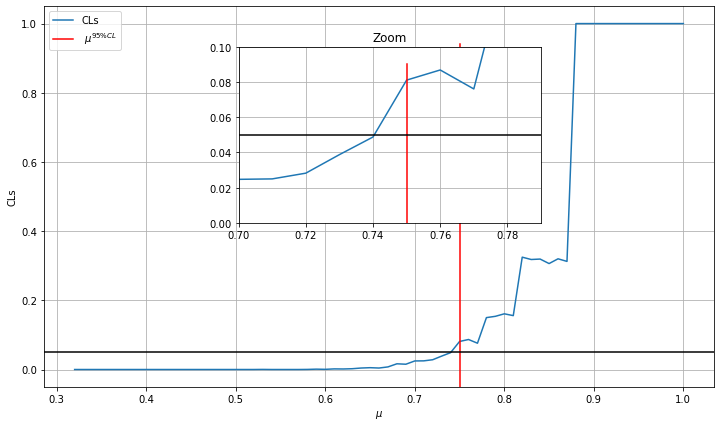

In [113]:
fig,ax = plt.subplots(figsize=(12,7))
ax.plot( mu_, CLs_val, label = 'CLs')
ax.axvline(x = mu_95, ymin = 0.0, ymax = 0.9, c = 'red', label = ' $\mu^{95\%CL}$')
ax.axhline(y = 0.05, c = 'black')
ax.set_xlabel('$\mu$')
ax.set_ylabel('CLs')
ax.legend()
ax.grid()

axes1 = plt.axes( [0.35, 0.45, 0.35, 0.35] )
axes1.set_title( 'Zoom' )
axes1.plot( mu_, CLs_val)
axes1.set_ylim(0,0.1)
axes1.set_xlim(0.70,0.79)
axes1.axvline(x = mu_95, ymin = 0.0, ymax = 0.9, c = 'red')
axes1.axhline(y = 0.05, c = 'black')
axes1.grid()

In [102]:
print('As we have a discrete variable μ we choose for the upper \
limit the value that provide the nearest value of CLs to 0.05 that is', round(CLs_95, 3))

As we have a discrete variable μ we choose for the upper limit the value that provide the nearest value of CLs to 0.05 that is 0.081


## Histogram representation of toy distributions for $\tilde{q}_{\mu}$

The two histograms for the signal and background hypothesis for the upper limit value of $\mu$, $\mu^{95\%CL}$ are plotted below. From the plot one can see that the histrograms are not overlapping at all, indicating that our data has a good resolution. This can be interpreted as our data showing a clear signal, as the distributions for a signal and no signal are clearly separated.

In [104]:
index_mu_95 = np.where(mu == mu_95)[0][0]
q_0_distr  = q_0_toys.iloc[:,index_mu_95]
q_mu_distr = q_mu_toys.iloc[:,index_mu_95]

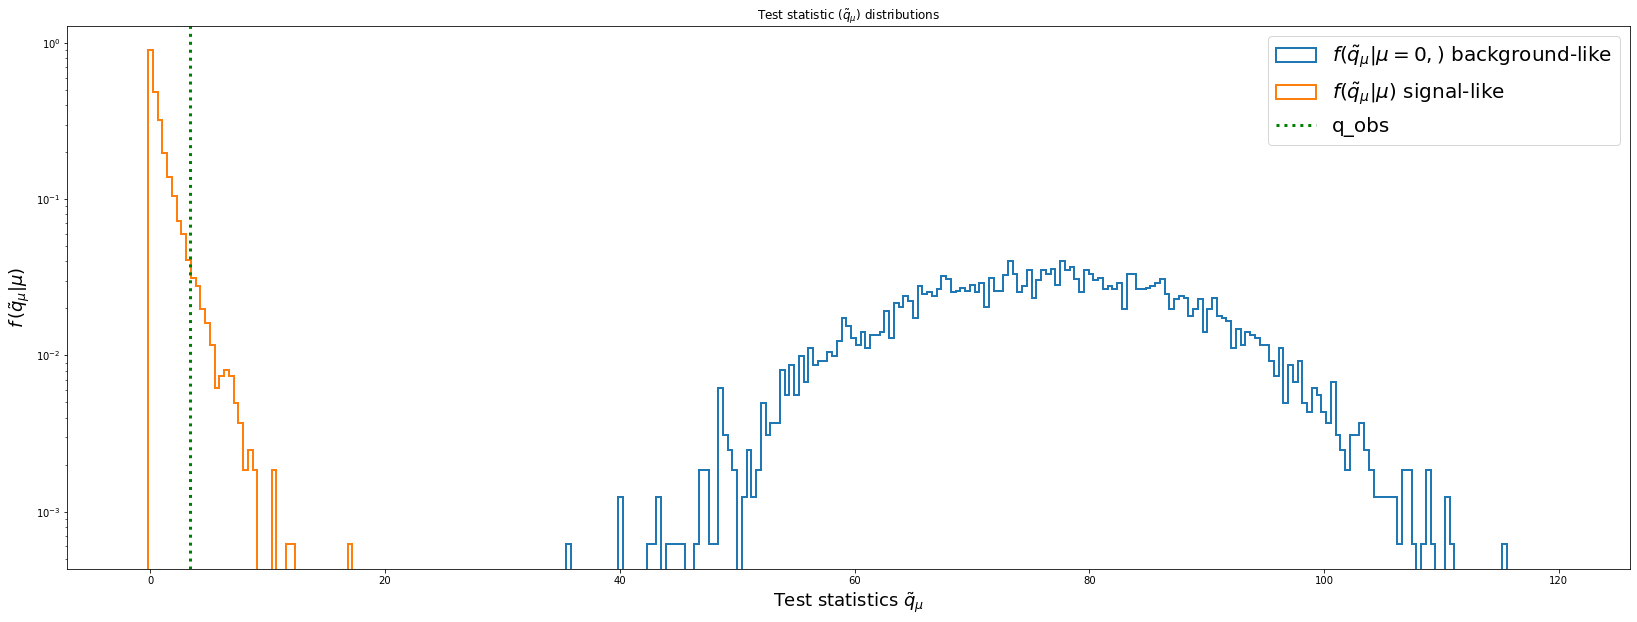

In [111]:
fig, ax = plt.subplots(1,1, figsize=(28,10))

bins = np.linspace(-1, 120, 300)

histogram_0 = ax.hist(q_0_distr, 
                       bins = bins,
                       histtype = 'step',
                       facecolor='c', 
                       density=True,
                       label=r"$f(\tilde{q}_{\mu }|\mu = 0, )$ background-like",
                       linewidth=2)

histogram_1 = ax.hist(q_mu_distr,
                       bins  = bins,
                       histtype = 'step',
                       facecolor='c',
                       density=True,
                       label =r"$f(\tilde{q}_{\mu }|\mu )$ signal-like",
                       linewidth=2)            

ax.axvline(q_tilde_obs.iloc[index_mu_95,:][0], color='green', linestyle='dotted', linewidth=3, label = "q_obs")
ax.set_yscale('log')
ax.set_xlabel(r"Test statistics $\tilde{q}_{\mu}$", fontsize=18)
ax.set_ylabel(r"$f\,(\tilde{q}_{\mu}|\mu)$", fontsize=18)
ax.set_title(r"Test statistic $(\tilde{q}_{\mu})$ distributions")
ax.legend(prop={'size': 20})


## Significance of an excess of events

The presence of the signal is quantified by the background-only p-value, i.e. the probability for the background to fluctuate and give an excess of events as large or larger than the observed one. As before, this requires defining a test statistic and the construction of its sampling distribution. For a given Higgs boson mass hypothesis, the test statistic used is $q_0$.

$$\tilde{q_0} =  - 2ln \frac{\mathcal{L}\left(\mbox{data}|0, \hat{\theta_{0}}\right)}{\mathcal{L}\left(\mbox{data}|\hat{\mu}, \hat{\theta}\right)},$$ 

It must be shown that the probability of collecting a signal with only backround noise is small enough to discard this hypothesis. In order to do so, we must integrate the pdf of $q_0$. This has been done by approximating the histogram with an exponential function and taking the integral of it. However, it was hard to obtain a perfect fit, which causes our approxiamtion to fully incorporate the intire histogram. However, it was found sufficient to give a good enough approximation for our p-value.

In [16]:
N      = 10**5
q_0_0s = np.zeros(N*10)

In [51]:
for i in tqdm(range(N*5)):
    toy_count0 = create_toy_distr(0, sim_signal_counts, sim_background_counts)
    
    fun0      = lambda x: -log_likelihood(x,
                                          sim_signal_counts,
                                          sim_background_counts,
                                          toy_count0) 

    
    params = sp.optimize.minimize(fun0,(0.5, 0.5),bounds=((0,1),(-1,1)))["x"]
    mu_s_0    = params[0]
    theta_s_0 = params[1]
    
    q_0_0s[i+(N*5)]   = q_tilde_mu(0, theta_0_obs, mu_s_0, theta_s_0, toy_count0)


100%|███████████████████████████████████████████████████████████| 500000/500000 [2:18:33<00:00, 60.14it/s]


In [89]:
%%cpp
TH1F *h = new TH1F("h", "h", 750, 3, 18); 
ifstream inp; 
double x; 
inp.open("q0_sample.txt"); 
while(!(inp >> x)==0){h->Fill(x);} 
// Double_t factor = 1.;
// h->Scale(factor/h->GetEntries());
TF1 f( "exp fit","expo");
h->Fit(&f);

 FCN=605.812 FROM MIGRAD    STATUS=CONVERGED      71 CALLS          72 TOTAL
                     EDM=4.17702e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     7.96444e+00   1.61675e-02   6.21813e-05   5.18210e-03
   2  Slope       -6.12061e-01   3.31455e-03   1.27478e-05   2.06764e-02


Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


In [90]:
def expo(x, a= 7.96e+00 , b = -6.12e-01):
    return np.exp( a + b*x )

x = np.linspace(1, 190, 10000)
y = expo(x)

In [91]:
q_0_0s = []
with open( 'q0_sample.txt', 'r' ) as in_file:
    for line in in_file:
        for q_0_0 in line.split( ): 
            q_0_0s.append( float(q_0_0) )


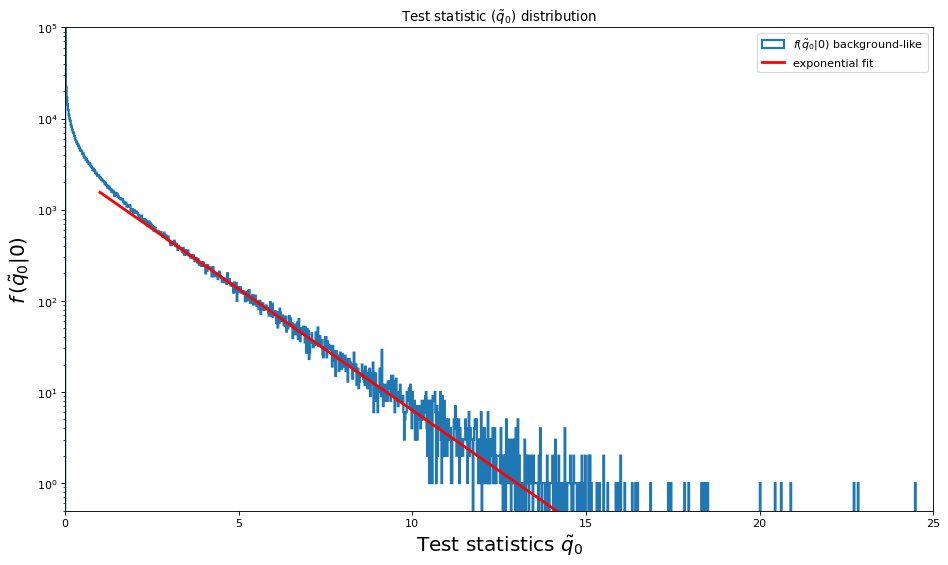

In [93]:
figure(figsize=(14, 8), dpi=80)
histogram_0 = plt.hist(q_0_0s, 
                       bins = 1250,
                       histtype = 'step',
                       facecolor='c', 
                       #density=True,
                       label=r"$f(\tilde{q}_0|0)$ background-like",
                       linewidth=2)


plt.plot(x, y, color = 'red', linewidth=2.5, label=r"exponential fit")

plt.xlabel(r"Test statistics $\tilde{q}_{0}$", fontsize=18)
plt.ylabel(r"$f\,(\tilde{q}_{0}|0)$", fontsize=18)
plt.title(r"Test statistic $(\tilde{q}_{0})$ distribution")
plt.yscale('log')
plt.ylim(0.5,100000)
plt.xlim(0,25)
plt.legend()

Now we can compute 
$$p_{0} = P\left(\tilde{q_{0}} \geq \tilde{q}_{0}^{obs}|\mbox{signal + background}\right) = \int_{\tilde{q}_{0}^{obs}}^{infty} f\left(\tilde{q}_{0}| 0,  \hat{\theta_{0}}^{obs} \right) dq_{0} $$

In [80]:
# Finding q0_obs as ratio of Likelihood-functions with mu = 0 and mu = best fit 
q_obs_0 = q_tilde_mu(0, theta_0_obs, mu_max, theta_max)
print("q_obs_0: ",q_obs_0)

q_obs_0:  [188.46005869]


In [81]:
# p-value computed integrating analitically the function that fit the distribution above
i       = integrate.quad(expo, 0 , np.inf)[0]
p_val_0 = integrate.quad(expo, q_obs_0 ,np.inf)[0]
p_val_0/i

2.621304514006636e-26

$\tilde{q}_{0}^{obs}$ is found to be above 188, which is far ourside the region of our distribution. Hence, the value $p_{0}$ we found for distribution is very small. It is smaller than expected, but we assume that is due to the clearly defined signal in our data, and the fact that our statistical treatment is somewhat simplified.

### Final result, cross section

As a last part of the project, we aimed to find the cros section of our interaction. 

    Fit of the peak: Gaussian 
    Fit for the bkg: a+bx

In [114]:
%%cpp

const int n_points =25;
double x_vals [ n_points ]={ 101.25, 103.75, 106.25, 108.75, 111.25, 113.75, 116.25, 118.75, 121.25, 123.75, 126.25, 128.75, 131.25, 133.75, 136.25, 138.75, 141.25, 143.75, 146.25, 148.75, 151.25, 153.75, 156.25, 158.75,161.25 };
double y_vals [ n_points ]={ 6.,  9.,  4.,  6., 14.,  3., 10.,  9., 16., 46., 27.,  9.,  7., 5., 16.,  8.,  3.,  8., 12.,  7.,  5.,  6.,  8.,  5.,  7. };
double y_errs [ n_points ]={ 2.45, 3., 2., 2.45, 3.74, 1.73, 3.16, 3., 4., 6.7, 5.20, 3., 2.65, 2.24, 4., 2.83, 1.73, 2.83, 3.46, 2.65, 2.24, 2.45, 2.83, 2.24, 2.65};
TGraphErrors graph(n_points ,x_vals , y_vals, NULL, y_errs ) ;
TF1 f( "PeakFit" , "gaus + [3] + [4]*x " , 100 , 160  ) ;
PeakFit->SetParameter(0, 1);
PeakFit->SetParameter(1, 127);
PeakFit->SetParameter(2, 1.65675);
//PeakFit->SetParameter(3, 1 );
//PeakFit->SetParameter(4, 0);

graph.Fit(&f);


 FCN=26.6431 FROM MIGRAD    STATUS=CONVERGED     379 CALLS         380 TOTAL
                     EDM=2.79018e-07    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.7 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           4.00234e+01   6.97896e+00   8.60362e-02  -2.08797e-05
   2  p1           1.24224e+02   2.72162e-01  -1.05557e-03  -2.22875e-03
   3  p2           1.82874e+00   2.84193e-01  -2.13590e-03  -2.46538e-03
   4  p3           5.41362e+00   3.72968e+00  -3.29395e-04   4.88487e-04
   5  p4           6.29988e-03   2.78879e-02  -1.43362e-05   6.52291e-02


In [115]:
# fit only the peak
Mass  = 1.24224e+02 
sigma = 1.82884e+00
N =  4.00234e+01
a =  5.41362e+00
b = 6.29988e-03
def fit_function_real( x, N = N, mu = Mass, sigma = sigma):
    return ( N*np.exp( -( x - mu )**2/( 2*sigma**2 )))

In [116]:
#N = 2.5*(sum(true_counts[6:13]))/(sigma*np.sqrt(2*np.pi))
def fit_function( x, N = N, mu = Mass, sigma = sigma, a = a, b = b):
    return ( N*np.exp( -( x - mu )**2/( 2*sigma**2 ))) + a + b*x

x = np.linspace(100, 160, 1000)
total_fit = fit_function(x)

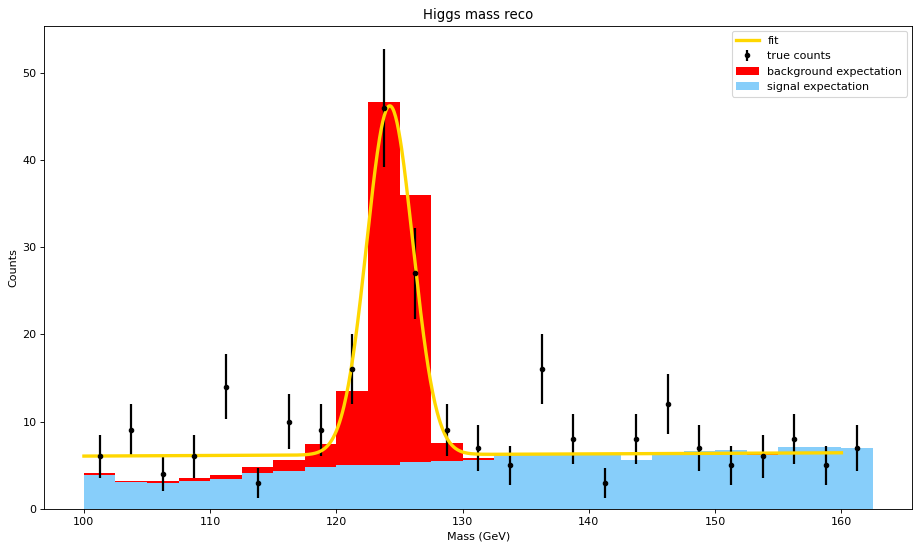

In [118]:
figure(figsize=(14, 8), dpi=80)

width      = [bin_counts[1] - bin_counts[0]]
bincenters = ( bin_counts[1:] + bin_counts[:-1]  ) / 2

plt.errorbar( bincenters[0:25], true_counts[0:25],
              yerr   = np.sqrt(true_counts[0:25]),
              markersize  = 8,
              fmt    = '.', 
              color  = 'black',
              linewidth = 2,
              label = 'true counts')

plt.bar(bincenters[0:25], sim_background_counts[0:25] + sim_signal_counts[0:25] , 
        color = 'red', alpha = 1, 
        width = width, label = 'background expectation'  )
plt.bar(bincenters[0:25], sim_background_counts[0:25] , 
        color = 'lightskyblue', alpha = 1, 
        width = width, label = 'signal expectation' )
plt.plot(x, total_fit, linewidth = 3, color ='gold', label = 'fit')
#ax.axvline(125.203, color='green', linestyle='dotted', linewidth=3, label = "q_obs")
#plt.grid()
plt.title("Higgs mass reco")
plt.xlabel("Mass (GeV)")
plt.ylabel("Counts")
plt.legend()

The fit provides the following estimation of the Higgs boson mass: 

m = $(124.2 \pm 0.3) GeV / c^2$

We perform the ratio between the area of the real data and the Monte Carlo simulation that should be equal to the experimental cross section normalized to the standard model cross section.

In [190]:
# fit the montecarlo signal peak

In [183]:
%%cpp
const int n_points =25;
double x_vals [ n_points ]={ 101.25, 103.75, 106.25, 108.75, 111.25, 113.75, 116.25, 118.75, 121.25, 123.75, 126.25, 128.75, 131.25, 133.75, 136.25, 138.75, 141.25, 143.75, 146.25, 148.75, 151.25, 153.75, 156.25, 158.75,161.25 };
double y_vals [ n_points ]={ 1.72527502e-01, 1.86151292e-01, 2.92355932e-01, 3.57908321e-01,
       4.66617711e-01, 7.15619011e-01, 1.25526479e+00, 2.65779862e+00,
       8.44184432e+00, 4.15429615e+01, 3.06647317e+01, 2.06958001e+00,
       2.11844903e-01, 4.08810976e-02, 1.23924608e-02, 9.12151281e-03,
       8.16222315e-03, 4.44599265e-03, 3.55434332e-03, 5.49285594e-03,
       5.50392750e-03, 6.91309361e-03, 2.03720787e-03, 2.39548055e-04}; 
double y_errs [ n_points ]={ 0.4153643 , 0.43145254, 0.54069948, 0.59825439, 0.68309422,
       0.84594268, 1.120386  , 1.63027563, 2.90548521, 6.44538296,
       5.53757453, 1.43860349, 0.46026612, 0.20219075, 0.11132143,
       0.09550661, 0.09034502, 0.06667828, 0.05961831, 0.0741138 ,
       0.07418846, 0.08314502, 0.04513544, 0.01547734, 0.04533976};

TGraphErrors graph(n_points ,x_vals , y_vals, NULL, y_errs ) ;
TF1 f( "PeakFit" , "gaus" , 100 , 160  ) ;
PeakFit->SetParameter(0, 1);
PeakFit->SetParameter(1, 125);
PeakFit->SetParameter(2, 1.65675);
//PeakFit->SetParameter(3, 1 );
//PeakFit->SetParameter(4, 0);

graph.Fit(&f);

 FCN=6.20523 FROM MIGRAD    STATUS=CONVERGED     108 CALLS         109 TOTAL
                     EDM=1.36773e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.69209e+01   6.50926e+00   6.75258e-03  -2.24944e-06
   2  Mean         1.24513e+02   1.99745e-01   2.53626e-04   2.56217e-04
   3  Sigma        1.76280e+00   1.49249e-01   2.05740e-05  -4.06720e-04


In [121]:
Mass_sim  =  1.24513e+02
sigma_sim =  1.76280e+00
N_sim     =  4.69209e+01
def fit_function_sim( x, N = N_sim, mu = Mass_sim, sigma = sigma_sim):
    return ( N*np.exp( -( x - mu )**2/( 2*sigma**2 )))

In [122]:
# integral of real signal
real = integrate.quad(fit_function_real, 100, np.inf)[0]
# integral of sim signal
sim = integrate.quad(fit_function_sim, 100, np.inf)[0]
# ratio
ratio_real_SM = real/sim
ratio_real_SM
# Bigger than mu_95%

0.8849532236362567

Then we obtain an estimation of the total cross section multiplying the standard model value by $\mu^{95\%CL}$

In [133]:
sigmaSM_tot = 55.7 #pb
sigma = sigmaSM_tot*mu_95
print('sigma =',round(sigma, 3), 'pb')

sigma = 41.775 pb
